In [1]:
import os, sys
root_path = os.path.abspath('.').split('jupyters')[0]
sys.path.append(root_path)

import json
import argparse
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

from data_loader import load_data
from models.cnn_geo import CNN_geo
from models.modules import Feature_Extractor, Correlation_network, Spatial_transformer_regressor

from utils import image, visualize
import geo_transform as tps
from train_CNNgeo import train_debug as train

In [2]:
with open('../overfit.json') as fp:
    config = json.load(fp)

config['backbone'] = 'prototypical_network' #vgg16
config['train']['learning_rate'] = 1E-5
config['train']['n_examples'] = 1
config['train']['batch_size'] = 1
config['train']['epochs'] = 200
    
print("backbone : ", config['backbone'])
print("n_examples : ", config['train']['n_examples'])
print("learning_rate : ", config['train']['learning_rate'])
print("batch_size : ", config['train']['batch_size'])
print("epoch num : ", config['train']['epochs'])

backbone :  prototypical_network
n_examples :  1
learning_rate :  1e-05
batch_size :  1
epoch num :  200


In [3]:
np.set_printoptions(formatter = {"float_kind" : lambda x : "{0:0.4f}".format(x)} )
#np.set_printoptions(formatter={'float_kind': lambda x: "{0:0.3f}".format(x)})

# 1. Training

In [4]:
model, x, y_loss, y_score_std = train(config, tentative_penalty=False)

train dataset amount : 1
Epoch 1, Loss: 5.46534538269043, score std 0.05037830024957657
Epoch 2, Loss: 4.462783336639404, score std 0.05121632292866707
Epoch 3, Loss: 3.7306735515594482, score std 0.05091216042637825
Epoch 4, Loss: 3.2247047424316406, score std 0.05118891969323158
Epoch 5, Loss: 2.7721927165985107, score std 0.053998809307813644
Epoch 6, Loss: 2.5014545917510986, score std 0.05330098420381546
Epoch 7, Loss: 2.2092134952545166, score std 0.05589484050869942
Epoch 8, Loss: 2.0560953617095947, score std 0.05528790131211281
Epoch 9, Loss: 1.9230180978775024, score std 0.05532623827457428
Epoch 10, Loss: 1.814951777458191, score std 0.05544928461313248
Epoch 11, Loss: 1.5258986949920654, score std 0.05636686086654663
Epoch 12, Loss: 1.2261536121368408, score std 0.05600528419017792
Epoch 13, Loss: 1.2739267349243164, score std 0.056159839034080505
Epoch 14, Loss: 0.9707615971565247, score std 0.05746724084019661
Epoch 15, Loss: 1.0922828912734985, score std 0.05892760679125

Epoch 125, Loss: 0.45536476373672485, score std 0.06958021968603134
Epoch 126, Loss: 0.47429749369621277, score std 0.07234559953212738
Epoch 127, Loss: 0.5350006222724915, score std 0.06915158033370972
Epoch 128, Loss: 0.44301292300224304, score std 0.07265389710664749
Epoch 129, Loss: 0.6065037846565247, score std 0.07142303884029388
Epoch 130, Loss: 0.618390679359436, score std 0.06850901991128922
Epoch 131, Loss: 0.5695754289627075, score std 0.06835638731718063
Epoch 132, Loss: 0.4783625602722168, score std 0.07229503989219666
Epoch 133, Loss: 0.6444051265716553, score std 0.07085820287466049
Epoch 134, Loss: 0.5356542468070984, score std 0.06820737570524216
Epoch 135, Loss: 0.597683846950531, score std 0.07027376443147659
Epoch 136, Loss: 0.5125606060028076, score std 0.06909974664449692
Epoch 137, Loss: 0.5185201168060303, score std 0.07167061418294907
Epoch 138, Loss: 0.4571685791015625, score std 0.0690261498093605
Epoch 139, Loss: 0.5542823076248169, score std 0.0718680471181

# 2. loss & std-dev of correlations graph

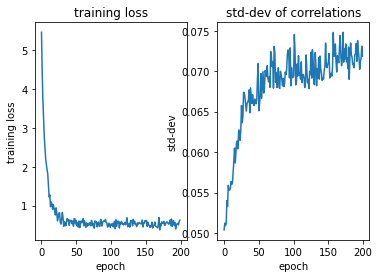

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.title.set_text("training loss")
ax1.set_xlabel("epoch")
ax1.set_ylabel("training loss")
ax1.plot(np.array(x), np.array(y_loss))

ax2.title.set_text("std-dev of correlations")
ax2.set_xlabel("epoch")
ax2.set_ylabel("std-dev")
ax2.plot(np.array(x), np.array(y_score_std))

# 3. Prediction test

In [6]:
datasets = load_data(['train'], config)
ds = datasets['train'].batch(1)

train dataset amount : 1


In [7]:
bordersize = 20
list_image_A = []
list_image_B = []
list_mps = []
list_pred = []
for epoch in range(10):
    for image_A, image_B, motion_parameters in ds.take(1):
        pred, score = model(image_A, image_B)
    image_A = image_A.numpy()
    image_B = image_B.numpy()
    motion_parameters = motion_parameters.numpy()
    pred = pred.numpy()
    list_image_A.append(image_A)
    list_image_B.append(image_B)
    list_mps.append(motion_parameters)
    list_pred.append(pred)

images_A = np.concatenate(list_image_A, axis=0)
images_B = np.concatenate(list_image_B, axis=0)
motion_parameters = np.concatenate(list_mps, axis=0)
pred = np.concatenate(list_pred, axis=0)
        
N,H,W = images_A.shape[0], images_A.shape[1], images_A.shape[2]
images_A = np.array(list(map(lambda image : visualize.makeBorder(image,bordersize) ,images_A)))
images_B = np.array(list(map(lambda image : visualize.makeBorder(image,bordersize) ,images_B)))

white_board = np.ones([N,64+2*bordersize,64+2*bordersize,3], np.float32)
motion_parameters = np.array(list(map(lambda image, mp : visualize.draw_arrow(image,bordersize,mp) 
                                     ,white_board, motion_parameters)))
predictions = np.array(list(map(lambda image, parameter : visualize.draw_arrow(image,bordersize,parameter) 
                                     ,white_board, pred)))
images = np.stack([images_A, motion_parameters, images_B, predictions], axis=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

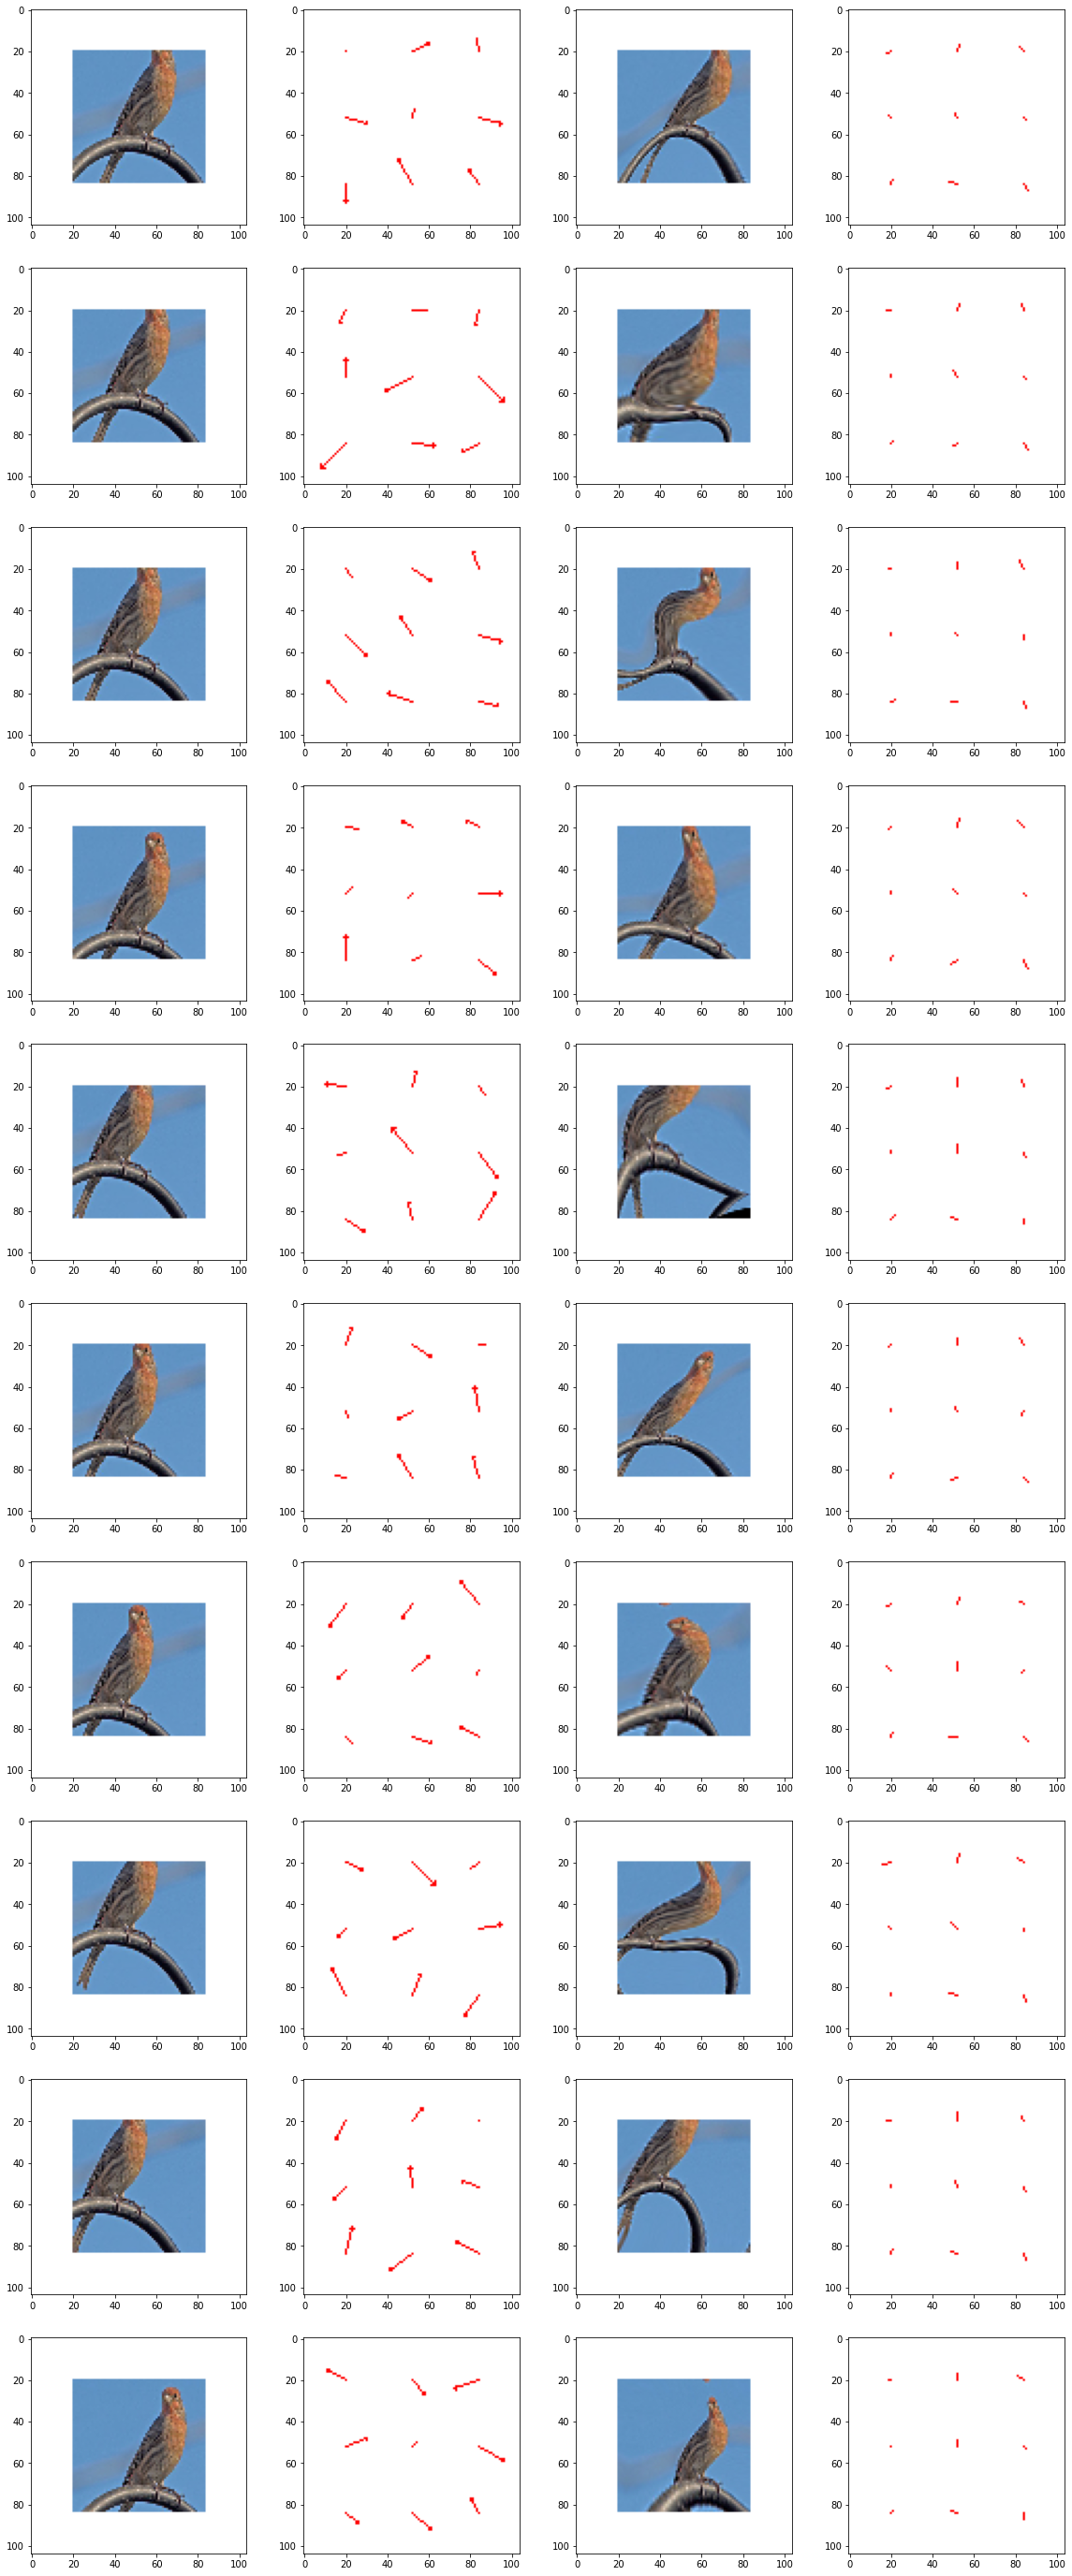

In [8]:
visualize.show_image(images)

# 4. Moving patch correlation test

In [4]:
def find_best_matching_from_B(motion_parameters, A_point, dshape = (16, 16)):
    src_points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    dst_points = src_points + motion_parameters
    theta = tps.tps_theta_from_points(src_points, dst_points, reduced=True)
    grid = tps.tps_grid(theta, dst_points, dshape)
    mapx, mapy = tps.tps_grid_to_remap(grid, dshape)
    points = np.concatenate([mapx[:,:,np.newaxis], mapy[:,:,np.newaxis]], axis=2)
    A_point = np.array(A_point)
    A_point = A_point[np.newaxis, np.newaxis, :]
    distance = np.sum(np.power((points - A_point), 2), axis=2) # NxN
    H,W = distance.shape
    yi, xi = distance.argmin()//W, distance.argmin()%W
    return (xi, yi)

In [7]:
src_points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
dst_points = src_points + 0
theta = tps.tps_theta_from_points(src_points, dst_points, reduced=True)
grid = tps.tps_grid(theta, dst_points, (32,32))
mapx, mapy = tps.tps_grid_to_remap(grid, (32,32))


In [9]:
mapx.shape

(32, 32)

In [10]:
mapx

array([[0.0000, 1.0000, 2.0000, ..., 29.0000, 30.0000, 31.0000],
       [0.0000, 1.0000, 2.0000, ..., 29.0000, 30.0000, 31.0000],
       [0.0000, 1.0000, 2.0000, ..., 29.0000, 30.0000, 31.0000],
       ...,
       [0.0000, 1.0000, 2.0000, ..., 29.0000, 30.0000, 31.0000],
       [0.0000, 1.0000, 2.0000, ..., 29.0000, 30.0000, 31.0000],
       [0.0000, 1.0000, 2.0000, ..., 29.0000, 30.0000, 31.0000]],
      dtype=float32)

In [10]:
import matplotlib.patches as patches
def draw_bbox(plt_ax, bbox, color = (0.,1.,0.), text=None):
    #bbox = (xmin,ymin,xmax,ymax)
    xmin,ymin,xmax,ymax = bbox
    w = xmax - xmin
    h = ymax - ymin
    plt_ax.add_patch(patches.Rectangle( (xmin,ymin), w,h, linewidth=1, edgecolor=color,
                                         facecolor="none"))
    if text is not None:
        plt.text(xmin,ymin, s=text, color="white", verticalalignment="top",
                bbox={"color" : color, "pad" : 0})

In [11]:
def make_heatmap(patch_score):
    _min = patch_score.min()
    _max = patch_score.max()
    _range = _max - _min
    
    normalized_pathch_score = (patch_score - _min)/_range
    return normalized_pathch_score

In [43]:
def patch_test(grid_point, grid_shape, image_A, image_B, correlations, motion_parameters):
    x, y = grid_point
    H, W, C = image_A.shape
    grid_H, grid_W = H/grid_shape[0], W/grid_shape[1]
    scores = correlations[y, x]
    
    fig = plt.figure()
    ax1 = fig.add_subplot(141)
    ax2 = fig.add_subplot(142)
    ax3 = fig.add_subplot(143)
    ax4 = fig.add_subplot(144)
    
    ax1.imshow(image_A)
    patch_minx, patch_miny = x*grid_W, y*grid_H
    patch_maxx, patch_maxy = (x+1)*grid_W, (y+1)*grid_H
    draw_bbox(ax1, (patch_minx, patch_miny, patch_maxx, patch_maxy), color=(0.,1.,0.))
    xi, yi = find_best_matching_from_B(motion_parameters, (x,y), dshape = grid_shape)
    score = scores[yi, xi]
    ax2.imshow(image_B)
    heat_map = make_heatmap(scores)
    ax3.imshow(heat_map, cmap='gray')
    patch_minx, patch_miny = xi*grid_W, yi*grid_H
    patch_maxx, patch_maxy = (xi+1)*grid_W, (yi+1)*grid_H
    draw_bbox(ax2, (patch_minx, patch_miny, patch_maxx, patch_maxy), 
              color=(0.,1.,0.))
    draw_bbox(ax3, (xi-0.5, yi-0.5, xi+0.5, yi+0.5), 
              color=(0.,1.,0.))
    flat_scores = np.reshape(scores, [-1])
    for i in range(0, 5):
        if i == 0:
            color = (0., 0., 1.)
        else:
            color = (1., 0., 0.)
        idx = np.where(np.argsort(-flat_scores) == i)[0][0]
        xj = idx//grid_shape[1]
        yj = idx%grid_shape[1]
        score = scores[yj, xj]
        patch_minx, patch_miny = xj*grid_W, yj*grid_H
        patch_maxx, patch_maxy = (xj+1)*grid_W, (yj+1)*grid_H
        draw_bbox(ax2, (patch_minx, patch_miny, patch_maxx, patch_maxy), 
              color=color)    
        draw_bbox(ax3, (xj-0.5, yj-0.5, xj+0.5, yj+0.5), 
                  color=color)
    
    heat_map = make_heatmap(scores)
    ax3.imshow(heat_map, cmap='gray')
    n, bins, patches = ax4.hist(scores, facecolor='blue', alpha=0.5)
    #n, bins, patches = ax4.hist(patch_score, bins=5, density=False, facecolor='blue', alpha=0.5)
    plt.show()

### 동일 영상

(16, 16)


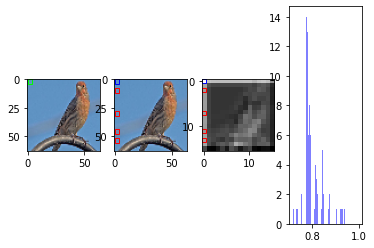

In [44]:
for image_A, image_B, motion_parameters in ds.take(1):
    image_A = image_A.numpy()
    image_B = image_B.numpy()
    motion_parameters = motion_parameters.numpy()
pred, correlations = model(image_A, image_A)
correlations = correlations.numpy()[0]
motion_parameters = motion_parameters[0]
image_A = image_A[0]
image_B = image_B[0]

grid_shape = (16, 16)
patch_test((0,0), grid_shape, image_A, image_A, correlations, motion_parameters=0)
# for i in range(16):
#     patch_test((i,i), grid_shape, image_A, image_A, correlations, motion_parameters)

## 다른 영상

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


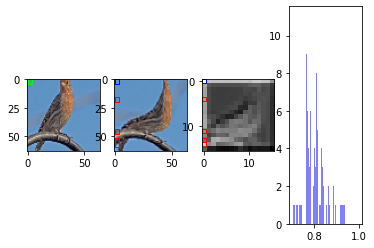

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


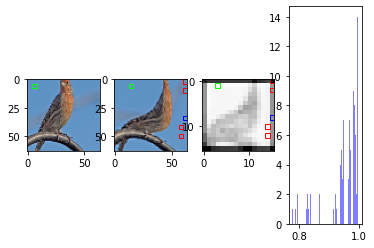

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


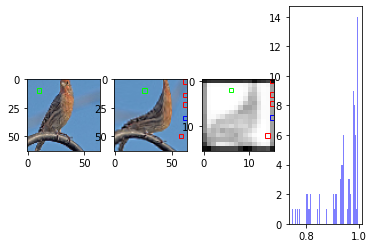

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


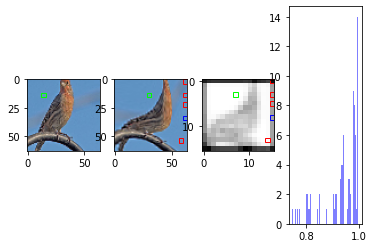

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


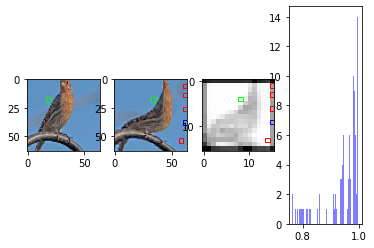

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


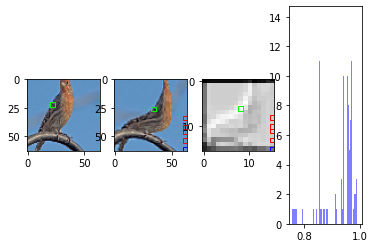

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


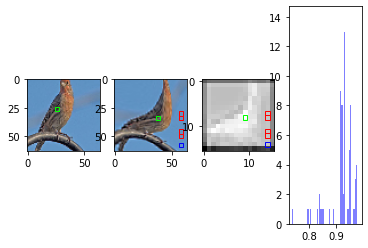

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


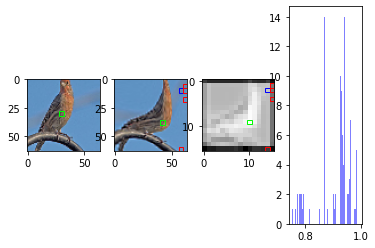

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


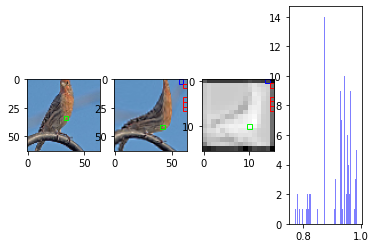

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


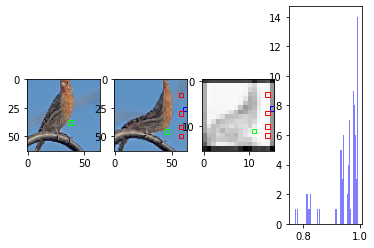

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


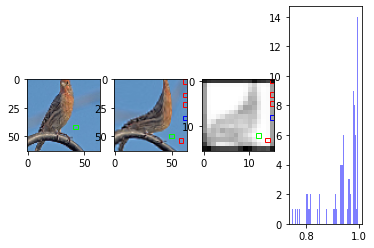

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


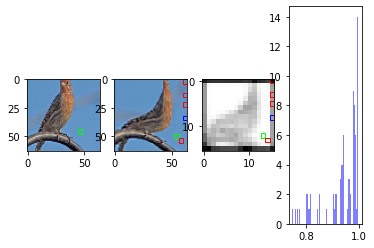

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


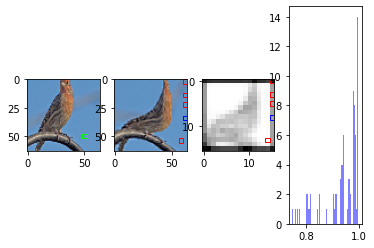

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


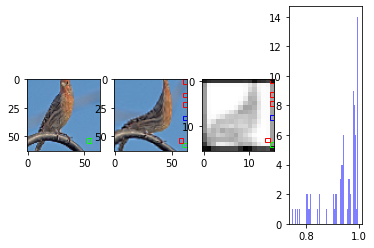

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


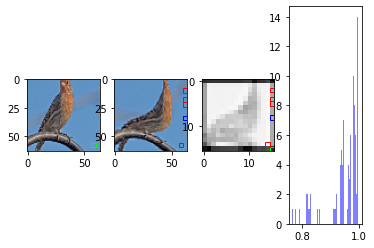

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 16)


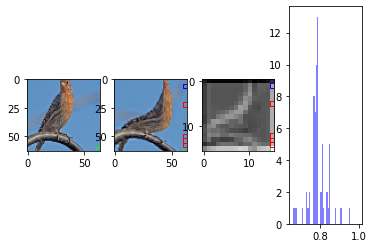

In [45]:
for image_A, image_B, motion_parameters in ds.take(1):
    image_A = image_A.numpy()
    image_B = image_B.numpy()
    motion_parameters = motion_parameters.numpy()
pred, correlations = model(image_A, image_B)
scores = correlations.numpy()[0]
motion_parameters = motion_parameters[0]
image_A = image_A[0]
image_B = image_B[0]

grid_shape = (16, 16)
for i in range(16):
    patch_test((i,i), grid_shape, image_A, image_B, scores, motion_parameters)